In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [134]:
def extract_feature(path):
    y, _ = librosa.load(path, offset=1.0, duration=2.0)
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    times = librosa.times_like(f0)
    midi = librosa.hz_to_midi(f0)

    diff = np.nanmax(midi)-np.nanmin(midi)

    minim = np.nanmin(midi)
    maxim = np.nanmax(midi)
    mini = [i for i,x in enumerate(midi) if x == minim]
    maxi = [i for i,x in enumerate(midi) if x == maxim]
    if max(times[mini]) > min(times[maxi]):
        time_diff = np.abs(min(times[mini])-max(times[maxi]))
    else:
        time_diff = np.abs(max(times[mini])-min(times[maxi]))

    return [diff, time_diff]

In [136]:
data = []

dataset_path = '../data/guitar/wav'

list_dir = os.listdir(dataset_path)
list_dir.sort()
list_dir

for directory in list_dir:
    tone_type = directory

    subpath = os.path.join(dataset_path, directory)
    list_subdir = os.listdir(subpath)
    list_subdir.sort()
    for subdirectory in list_subdir:
        subtechnique = subdirectory
        technique = subdirectory.split('_')[0]

        sub2path = os.path.join(subpath, subdirectory)
        list_audio = os.listdir(sub2path)
        list_audio.sort()
        for audio in list_audio:
            audio_path = os.path.join(sub2path, audio)
            # print([technique, subtechnique, tone_type, audio_path])
            feature = extract_feature(audio_path)
            feature = np.append(feature, [technique, subtechnique, tone_type, audio_path])
            data.append(feature)

<ipython-input-134-0f1a576563bb>:7: RuntimeWarning: All-NaN slice encountered
  diff = np.nanmax(midi)-np.nanmin(midi)
<ipython-input-134-0f1a576563bb>:9: RuntimeWarning: All-NaN slice encountered
  minim = np.nanmin(midi)
<ipython-input-134-0f1a576563bb>:10: RuntimeWarning: All-NaN slice encountered
  maxim = np.nanmax(midi)


ValueError: max() arg is an empty sequence

In [137]:
columns = ['diff', 'time_diff', 'technique', 'subtechnique', 'tone_type', 'audio_path']
df = pd.DataFrame(data, columns=columns)
df

,diff,time_diff,technique,subtechnique,tone_type,audio_path
0,0.8999999999999915,0.11609977324263038,bending,bending_up_down_half,1,../data/guitar/wav_split/1/bending_up_down_hal...
1,1.1000000000000085,0.16253968253968254,bending,bending_up_down_half,1,../data/guitar/wav_split/1/bending_up_down_hal...
2,1.1999999999999886,0.18575963718820862,bending,bending_up_down_half,1,../data/guitar/wav_split/1/bending_up_down_hal...
3,1.2000000000000028,0.2089795918367347,bending,bending_up_down_half,1,../data/guitar/wav_split/1/bending_up_down_hal...
4,1.0,0.18575963718820862,bending,bending_up_down_half,1,../data/guitar/wav_split/1/bending_up_down_hal...
...,...,...,...,...,...,...
1634,0.09999999999999432,0.02321995464852608,normal,normal_half_step_down,2,../data/guitar/wav_split/2/normal_half_step_do...
1635,0.9000000000000057,0.09287981859410431,normal,normal_half_step_down,2,../data/guitar/wav_split/2/normal_half_step_do...
1636,0.3999999999999915,0.18575963718820865,normal,normal_half_step_down,2,../data/guitar/wav_split/2/normal_half_step_do...
1637,0.09999999999999432,0.13931972789115646,normal,normal_half_step_down,2,../data/guitar/wav_split/2/normal_half_step_do...


In [138]:
import plotly.express as px
fig = px.scatter(df, x="diff", y="time_diff", color='technique')
fig.show()

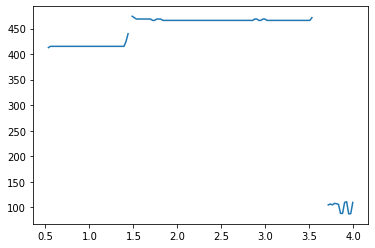

In [64]:
path = 'data/guitar/wav/1/normal_whole_step_up/normal_whole_step_up_9.wav'
y, sr = librosa.load('../'+path, duration=4.0)
f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times2 = librosa.times_like(f0)
midi = librosa.hz_to_midi(f0)

plt.plot(times2, f0)

In [61]:
from scipy.signal import butter,filtfilt
def butter_highpass(data,cutoff, fs, order=5):
   """
   Design a highpass filter.
   Args:
   - cutoff (float) : the cutoff frequency of the filter.
   - fs     (float) : the sampling rate.
   - order    (int) : order of the filter, by default defined to 5.
   """
   # calculate the Nyquist frequency
   nyq = 0.5 * fs
   # design filter
   high = cutoff / nyq
   b, a = butter(order, high, btype='high', analog=False)
   # returns the filter coefficients: numerator and denominator
   y = filtfilt(b, a, data)
   return y
x=butter_highpass(y, 150, sr, order=5)

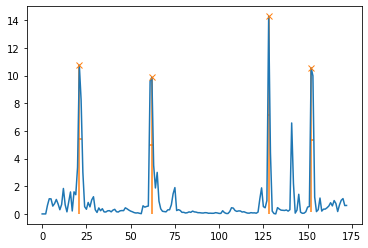

In [66]:
from scipy.signal import find_peaks
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)

peaks, properties = find_peaks(o_env, prominence=7, width=1)
plt.plot(o_env)
plt.plot(peaks, o_env[peaks], "x")
plt.vlines(x=peaks, ymin=o_env[peaks] - properties["prominences"],
           ymax = o_env[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")
plt.show()

In [40]:
peaks

array([], dtype=int64)